In [1]:
import scipy
import random
import portpy.photon as pp
import numpy as np
from cvxpy import *
from scipy import sparse
import sklearn.metrics
import cProfile
import time
import sys
import psutil
from sklearn.decomposition import PCA
import cvxpy as cp
import matplotlib.pyplot as plt

In [2]:
data_dir = r'../data'
data = pp.DataExplorer(data_dir=data_dir)
patient_id = 'Lung_Phantom_Patient_1'
data.patient_id = patient_id
ct = pp.CT(data)
structs = pp.Structures(data)
beams = pp.Beams(data)
opt_params = data.load_config_opt_params(protocol_name='Lung_2Gy_30Fx')
structs.create_opt_structures(opt_params)
inf_matrix_sparse = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams)
protocol_name = 'Lung_2Gy_30Fx'
clinical_criteria = pp.ClinicalCriteria(data, protocol_name)
plan_sparse = pp.Plan(ct, structs, beams, inf_matrix_sparse, clinical_criteria)
opt = pp.Optimization(plan_sparse, opt_params=opt_params)
opt.create_cvxpy_problem()

sol_sparse = opt.solve(solver='MOSEK', verbose=True)
dose_sparse_1d = plan_sparse.inf_matrix.A @ (sol_sparse['optimal_intensity'] * plan_sparse.get_num_of_fractions())
x_sparse =sol_sparse['optimal_intensity'] * plan_sparse.get_num_of_fractions()

beams_full = pp.Beams(data, load_inf_matrix_full=True)
inf_matrix_full = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams_full, is_full=True)
plan_full = pp.Plan(ct, structs, beams, inf_matrix_full, clinical_criteria)
dose_full_1d = plan_full.inf_matrix.A @ (sol_sparse['optimal_intensity'] * plan_full.get_num_of_fractions())

A_dense = plan_full.inf_matrix.A


creating rinds.. This step may take some time due to dilation
rinds created!!
Creating BEV..
Loading sparse influence matrix...
Done
Objective Start
Objective done
Constraints Start
Structure ESOPHAGUS not available!
Structure ESOPHAGUS not available!
Constraints done
                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Sep 09 03:51:51 PM: Your problem has 1946 variables, 110663 constraints, and 0 parameters.
(CVXPY) Sep 09 03:51:51 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 09 03:51:51 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 09 03:51:51 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Sep 09 03:51:51 PM: Your problem is compiled with the CPP canonicalization backend.
------------------------------------

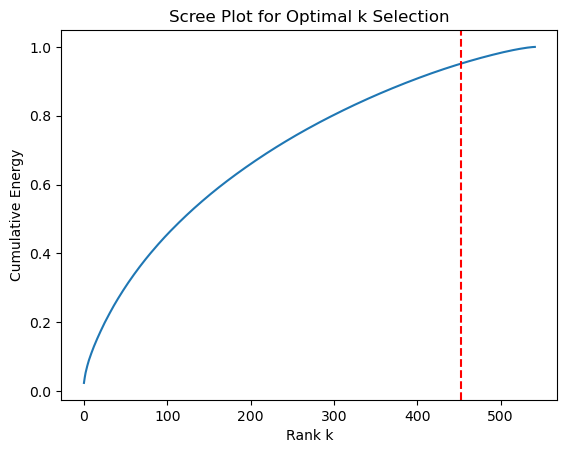

Optimal k: 452


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def optimal_k(A, threshold=0.95):
    
    U, Sigma, VT = np.linalg.svd(A, full_matrices=False)
    #  Cumulative Energy 
    cumulative_energy = np.cumsum(Sigma**2) / np.sum(Sigma**2)
    
    # Threshold
    k_optimal = np.where(cumulative_energy >= threshold)[0][0] + 1
    
    plt.plot(cumulative_energy)
    plt.xlabel('Rank k')
    plt.ylabel('Cumulative Energy')
    plt.title('Scree Plot for Optimal k Selection')
    plt.axvline(x=k_optimal, color='r', linestyle='--')
    plt.show()
    
    return k_optimal

# Optimal k
k_opt = optimal_k(A_dense, threshold=0.95)
print(f"Optimal k: {k_opt}")


In [13]:
import numpy as np
from scipy.linalg import svd

def column_select(A, k, epsilon=0.1):
    U, Sigma, VT = svd(A, full_matrices=False)
    V = VT.T
    leverage_scores = np.sum(V[:, :k_opt]**2, axis=1) / k_opt

   
    c = int(np.ceil((k * np.log(k)) / epsilon**2))

    probabilities = np.minimum(1, c * leverage_scores)
    selected_columns = np.random.choice(A.shape[1], size=c, p=probabilities/probabilities.sum(), replace=True)
    
    C = A[:, selected_columns]
    return C, selected_columns

# A_sparse = csc_matrix(A_dense)

def cur_decomposition(A, k, epsilon=0.1):
    C, selected_columns = column_select(A_dense, k_opt, epsilon)
    R, selected_rows = column_select(A_dense.T, k_opt, epsilon)
    R = R.T
    
    U = np.linalg.pinv(C) @ A @ np.linalg.pinv(R)
    return C, U, R



In [15]:

C, U, R = cur_decomposition(A_dense, k_opt)

print("C matrix:\n", C[:3])
print("U matrix:\n", U[:3])
print("R matrix:\n", R[:3])


C matrix:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
U matrix:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
R matrix:
 [[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.9032709e-04 2.3651514e-04 2.6781193e-04 ... 1.9838099e-01
  3.3964068e-01 4.3557819e-02]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]]


In [ ]:
print(f'C: {C.shape},U: {U.shape}, R: {R.shape}')

In [ ]:
nonzero_count = (np.count_nonzero(A_dense))
print("nnz A Matrix: ", nonzero_count)

# Count non-zero entries in the sparsified matrix
nnz_S = (np.count_nonzero(A_approx_sparse))
print("nnz approx matrix:", nnz_S)

In [ ]:
rank1= np.linalg.matrix_rank(A)
print(f"Rank A: {rank1}")

rank2= np.linalg.matrix_rank(A_approx2.T@A)
print(f"Rank A_approx2 : {rank2}")